In [1]:
import numpy as np
from pyscf import gto, scf, fci
import matplotlib.pyplot as plt

In [2]:
def expand_matrix(P):
    Paa = P
    Pbb = P
    Pab = np.zeros(P.shape)
    Pba = np.zeros(P.shape)
    PE = np.concatenate((np.concatenate((Paa, Pab), axis=1), np.concatenate((Pba, Pbb), axis=1)), axis=0) 
    return PE

In [3]:
mol = gto.Mole()
mol.atom = """
    He    0.    0.    0.
"""
# this basis has 2 functions for Helium
mol.basis = "6-31g" 
#mol.basis = "ccpvdz"
#mol.basis = "sto-6g"
mol.build()

# the 2 electron integrals \langle \mu \nu | \kappa \lambda \rangle have M^4 entries
eri = mol.intor('int2e')
S = mol.intor('int1e_ovlp')

print(eri.shape)

## Run Hartree-Fock.
mf = scf.RHF(mol)
mf.kernel()

C = mf.mo_coeff
h = mf.get_hcore()

N = mol.nelec[0]
P=np.matmul(C[:,0:N],C[:,0:N].T)

gamma = np.matmul(np.matmul(C.T,np.matmul(np.matmul(S,P),S)), C)
occu, naturalC = np.linalg.eigh(gamma)

(2, 2, 2, 2)
converged SCF energy = -2.85516042615445


In [4]:
# need to first make gamma and then expand into blockdiagonal so "fake" alpha and "beta" are seperated in this fashion
CE = expand_matrix(C)
gamma = np.matmul(np.matmul(C.T,np.matmul(np.matmul(S,P),S)), C)
occu_aa, naturalC_aa = np.linalg.eigh(gamma)
occu = np.append(occu_aa, occu_aa)
naturalCE = expand_matrix(naturalC_aa)
naturalCTT = np.matmul(CE,naturalCE)

In [5]:
for i, n  in enumerate(occu):
    if n < 0:
        occu[i] = 0 


In [6]:
npoints = 100

coords = np.linspace(-1,1,npoints)
ao = mol.eval_gto('GTOval', coords)
plot = np.matmul(ao,np.matmul(P,ao.T))

[0.05044123 0.05383655 0.05745387 0.06130902 0.06541961 0.06980543
 0.07448868 0.07949437 0.0848507  0.09058942 0.09674622 0.10336117
 0.11047903 0.11814957 0.12642789 0.13537451 0.14505543 0.15554197
 0.16691048 0.17924166 0.19261969 0.20713103 0.22286278 0.23990078
 0.25832752 0.2782199  0.29964752 0.32267184 0.34734744 0.37372656
 0.40186847 0.4318553  0.46381525 0.49795286 0.53458341 0.57416542
 0.61732091 0.66482954 0.71757994 0.77646193 0.84218781 0.91504197
 0.99457819 1.07931174 1.16648527 1.25200997 1.33067775 1.39669229
 1.44447511 1.46959562 1.46959562 1.44447511 1.39669229 1.33067775
 1.25200997 1.16648527 1.07931174 0.99457819 0.91504197 0.84218781
 0.77646193 0.71757994 0.66482954 0.61732091 0.57416542 0.53458341
 0.49795286 0.46381525 0.4318553  0.40186847 0.37372656 0.34734744
 0.32267184 0.29964752 0.2782199  0.25832752 0.23990078 0.22286278
 0.20713103 0.19261969 0.17924166 0.16691048 0.15554197 0.14505543
 0.13537451 0.12642789 0.11814957 0.11047903 0.10336117 0.0967

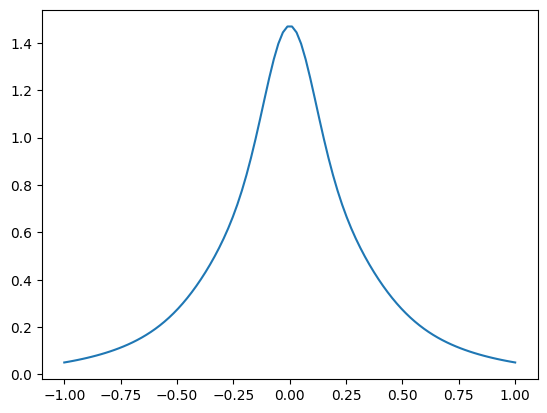

In [7]:
plt.plot(coords,np.diag(plot))
print(np.diag(plot))
plt.show()